# *MoMA's* artists and their collaboration network
## Data project for "2021W 136010-1 Introduction to DH Tools and Methods". 
##### Nora Linser (01315533) 2022-01-23

# Introduction
*The Museum of Modern Art* in New York provides two datasets on *github*, one containing the artists that are represented in their collections and the other one the artworks itselt. 
Ithe artworks themselves. 
I will use the datasets, particularly the artwork dataset, to conduct a social network analysis of the artists represented in the *MoMA* collections. In doing so, I will assume that there is a social connection between the artists who collaborated in the creation of an artwork. 

# Research question and objective
The goal of this project is to examine the dataset and create a network analysis based on the shared authorship of artworks by artists. 
A graph object will be created and centrality measures (Betwenness Centrality, Closeness Centrality, Degree distribution) will be calculated and displayed in plots (histograms and graphs). The size of the nodes in the respective diagrams should depend on the displayed centrality measures. Based on one of the centrality measures, a subgraph containing only the 100 most important nodes should be computed. A nice representation of this subgraph is the goal of the network investigation, where also some of the node attributes like gender or origin should be reflected (<font color =darkred>this part is not finished yet, but will be fulfilled in the Final Assignment</font>). 

# Source
*MoMA* notes in the README file on Github that some of the data is not complete and that other information is not "approved by the curator." They also make it clear that use of the data is at the user's risk. 
MoMA planned to update the records on Github monthly, but the last update was done in January 2021. This is also the version (1.62) that I downloaded to use for this project.

## Reference:  
- Data collected by: Moma – Museum of modern Art.
- Dataset: 15,222 records. Encoding: UTF-8. 
- Data format: .csv and JSON.
- Data distribution via [Github](https://github.com/MuseumofModernArt/collection) by the users John Halderman and momadm. 
- Licensing: CC0 License.
- Digital object identifier DOI: 10.5281/zenodo.4408594
- [Presidential URL](https://zenodo.org/record/4408594#.YcGKvC1h1pR)
- Version: v1.62, release date: 2021/01/01
- Day and time of download: 2021/12/21 12:43 PM 

## Short citation:
Moma – Museum of Modern Art (2021/01/01), Artists (Data file in CSV Format). Doi: 10.5281/zenodo.4408594. Retrieved from https://github.com/MuseumofModernArt/collection  

Moma – Museum of Modern Art (2021/01/01), Artwork (Data file in CSV Format). Doi: 10.5281/zenodo.4408594. Retrieved from https://github.com/MuseumofModernArt/collection 


# Importing the dataset and getting a first overview
Setting up the working environment:

In [117]:
#Setting up the working environment
import pandas as pd

Importing the files and displaying the first overview:

In [133]:
#Import the file downloaded from github
artworksAll = pd.read_csv("/Users/linsernora/Pyhton_Course/Python_CourseNorLins/MoMAartworks/Artworks.csv")
artworksAll.head(15)

,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,...,ThumbnailURL,Circumference (cm),Depth (cm),Diameter (cm),Height (cm),Length (cm),Weight (kg),Width (cm),Seat Height (cm),Duration (sec.)
0,"Ferdinandsbrücke Project, Vienna, Austria (Ele...",Otto Wagner,6210,"(Austrian, 1841–1918)",(Austrian),(1841),(1918),(Male),1896,Ink and cut-and-pasted painted pages on paper,...,http://www.moma.org/media/W1siZiIsIjU5NDA1Il0s...,NaN,NaN,NaN,48.6000,NaN,NaN,168.9000,NaN,NaN
1,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,7470,"(French, born 1944)",(French),(1944),(0),(Male),1987,Paint and colored pencil on print,...,http://www.moma.org/media/W1siZiIsIjk3Il0sWyJw...,NaN,NaN,NaN,40.6401,NaN,NaN,29.8451,NaN,NaN
2,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, pen, color pencil, ink, and gouache ...",...,http://www.moma.org/media/W1siZiIsIjk4Il0sWyJw...,NaN,NaN,NaN,34.3000,NaN,NaN,31.8000,NaN,NaN
3,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1980,Photographic reproduction with colored synthet...,...,http://www.moma.org/media/W1siZiIsIjEyNCJdLFsi...,NaN,NaN,NaN,50.8000,NaN,NaN,50.8000,NaN,NaN
4,"Villa, project, outside Vienna, Austria, Exter...",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, color pencil, ink, and gouache on tr...",...,http://www.moma.org/media/W1siZiIsIjEyNiJdLFsi...,NaN,NaN,NaN,38.4000,NaN,NaN,19.1000,NaN,NaN
5,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1976-77,Gelatin silver photograph,...,http://www.moma.org/media/W1siZiIsIjE0OCJdLFsi...,NaN,NaN,NaN,35.6000,NaN,NaN,45.7000,NaN,NaN
6,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1976-77,Gelatin silver photographs,...,http://www.moma.org/media/W1siZiIsIjE0OSJdLFsi...,NaN,NaN,NaN,35.6000,NaN,NaN,45.7000,NaN,NaN
7,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1976-77,Gelatin silver photograph,...,http://www.moma.org/media/W1siZiIsIjE0OSJdLFsi...,NaN,NaN,NaN,35.6000,NaN,NaN,45.7000,NaN,NaN
8,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1976-77,Gelatin silver photograph,...,http://www.moma.org/media/W1siZiIsIjE1MCJdLFsi...,NaN,NaN,NaN,35.6000,NaN,NaN,45.7000,NaN,NaN
9,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1976-77,Gelatin silver photograph,...,http://www.moma.org/media/W1siZiIsIjE1MSJdLFsi...,NaN,NaN,NaN,35.6000,NaN,NaN,45.7000,NaN,NaN


My first attemt to find out if there are objects listed with more than one artist in the Artist column was no very helpful.
I though my just printing a couple of rows I might get an impression of the data. 

Getting all the column labels.

In [120]:
#listing all the column headers of the dataset: 
list(artworksAll.columns.values)

['Title',
 'Artist',
 'ConstituentID',
 'ArtistBio',
 'Nationality',
 'BeginDate',
 'EndDate',
 'Gender',
 'Date',
 'Medium',
 'Dimensions',
 'CreditLine',
 'AccessionNumber',
 'Classification',
 'Department',
 'DateAcquired',
 'Cataloged',
 'ObjectID',
 'URL',
 'ThumbnailURL',
 'Circumference (cm)',
 'Depth (cm)',
 'Diameter (cm)',
 'Height (cm)',
 'Length (cm)',
 'Weight (kg)',
 'Width (cm)',
 'Seat Height (cm)',
 'Duration (sec.)']

## Finding multiple artist occurrences

I tried to find out if there are rows with more than on artist by using the .isin() method. 
At first I though that the given result would suggest that there are no commas in the column. 
To use this approach I would have needed to take further steps with this result and to find out in which columns the result is "True". 

In [121]:
#checking if there are rows with multiple artists in the Artist column
artists = artworksAll["Artist"]
multiple = artists.isin([","])
multiple.head()


0    False
1    False
2    False
3    False
4    False
Name: Artist, dtype: bool

The next apprach was more useful. Subsetting the rows that contain a "," in the "Artist" column and assigning it to a new DataFrame *multipleArtists*.
The .info() methods shows that there are 8059 entries in the dataset where there is more than one artist mentioned in the "Artist" column. 

In [122]:
#Subsetting the rows with more than one artist. 
multipleArtists = artworksAll[artworksAll["Artist"].str.contains(",")==True]
multipleArtists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8059 entries, 65 to 138146
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               8057 non-null   object 
 1   Artist              8059 non-null   object 
 2   ConstituentID       8059 non-null   object 
 3   ArtistBio           7786 non-null   object 
 4   Nationality         8059 non-null   object 
 5   BeginDate           8059 non-null   object 
 6   EndDate             8059 non-null   object 
 7   Gender              8059 non-null   object 
 8   Date                7710 non-null   object 
 9   Medium              7518 non-null   object 
 10  Dimensions          7500 non-null   object 
 11  CreditLine          7876 non-null   object 
 12  AccessionNumber     8059 non-null   object 
 13  Classification      8059 non-null   object 
 14  Department          8059 non-null   object 
 15  DateAcquired        7497 non-null   object 
 16  Cat

Before geoing any further I wanted to check if the dataset is restricted to show one object per row. As the result shows, there are no duplicate "ObjectID"'s in the dataset. 

In [123]:
#checking if there are objectsIds mentioned more than once: 
objectIds = artworksAll["ObjectID"]
artworksAll[objectIds.isin(objectIds[objectIds.duplicated()])]


,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,...,ThumbnailURL,Circumference (cm),Depth (cm),Diameter (cm),Height (cm),Length (cm),Weight (kg),Width (cm),Seat Height (cm),Duration (sec.)


## Cleaning the data
Reducing the columns that are not needed for the task.

In [124]:
#reducing the dataframe, only keeping the columns that are needed: 
multipleArtists = multipleArtists[["Title", "Artist", "ConstituentID", "ObjectID"]]

In [125]:
#checking if it worked: 
multipleArtists.head()

,Title,Artist,ConstituentID,ObjectID
65,"House IV Project, Falls Village, Connecticut (...","Peter Eisenman, Robert Cole","6969, 8134",81
66,"Villa dall'Ava, Paris (Saint-Cloud), France, E...","Rem Koolhaas, Madelon Vriesendorp","6956, 6957",82
76,"Regional Administrative Center, project ""Tries...","Aldo Rossi, Gianni Braghieri, M. Bosshard","7661, 8131, 8180",100
107,"Woodland Crematorium, Woodland Cemetery, Stock...","Erik Gunnar Asplund, Sigurd Lewerentz","27, 24452",148
110,"Palais de la Découverte Project, Paris, France...","Paul Nelson, Frantz Jourdain, Oscar Nitzchke","8102, 6703, 4312",151


In [126]:
multipleArtists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8059 entries, 65 to 138146
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          8057 non-null   object
 1   Artist         8059 non-null   object
 2   ConstituentID  8059 non-null   object
 3   ObjectID       8059 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 314.8+ KB


### Splitting up the values
Next step is to split up the values from the columns "Artist", "Constitutent ID" and "Title" into separate rows. 
So that each artist occurrence is mentioned in its own row. The data in the columns "Title" and "ObjektID" needs to be copied to the new observations. 

With a little help of *stackoverflow* I created the following approach of stacking and unstacking that provides me with the desired output. I created a new dataframe with the result called *singleArtist*.

In [127]:
#Stacking and unstacking the data to move every artist-occurrence from the "Artist" column into separate lines. 
#Without loosing the data that needs to be copied. 
singleArtist = (multipleArtists.set_index(['Title', 'ObjectID'])
   .stack()
   .str.split(',', expand=True)
   .stack()
   .unstack(-2)
   .reset_index(-1, drop=True)
   .reset_index()
)

In [128]:
#calling singleArtist to see if it worked: 
singleArtist

,Title,ObjectID,Artist,ConstituentID
0,NaN,136435,Brian Buczak,37999
1,NaN,136435,Geoffrey Hendricks,2591
2,NaN,136971,George Maciunas,21398
3,NaN,136971,Giuseppe Chiari,36943
4,!,139486,Hi Red Center,36946
...,...,...,...,...
24895,"Über Sieben Brücken Mußt Du Gehen,",195085,Thomas Wachweger,48388
24896,"Šerefudin White Mosque, Visoko, Bosnia and Her...",273898,Valentin Jeck,69800
24897,"Šerefudin White Mosque, Visoko, Bosnia and Her...",273898,Zlatko Ugljen,50030
24898,“Off-Air” Australia,292298,Ant Farm,32176


Investing if the first rows do not hold any data in the Title column or if something went wrong there. 

In [129]:
#chechking if the object does not have a title of if I made I mistake: 
multipleArtists[multipleArtists["ObjectID"] == 136435]

,Title,Artist,ConstituentID,ObjectID
101013,NaN,"Brian Buczak, Geoffrey Hendricks","37999, 2591",136435


The artwork does not hold any data as Titel.
Making sure the stacking worked and also the constiutent IDs were split up accordingly to the artist names. 

In [130]:
#checking if I split up the Constitutent IDs correctly
singleArtist[singleArtist["ObjectID"] == 81]

,Title,ObjectID,Artist,ConstituentID
10153,"House IV Project, Falls Village, Connecticut (...",81,Peter Eisenman,6969
10154,"House IV Project, Falls Village, Connecticut (...",81,Robert Cole,8134


In [131]:
singleArtist[singleArtist["Artist"] == "Peter Eisenman"]

,Title,ObjectID,Artist,ConstituentID
10153,"House IV Project, Falls Village, Connecticut (...",81,Peter Eisenman,6969


The multiple occurrences in the "Artist"Column are split up into separate lines, the metadata was copied in to the lines as wanted. 

Before adding the additional rows for each artist, the dataframe contained 'r: mutipleArtists.count()' 8059 elements. Now, after splitting up the multiple occurrences, the dataframe holds 24900 elements. 
This might be to big to comfortable work with in my environment, but I will try it out. 

## Creating a Graph object
To investigate the network and to be able to draw graphs

Creating a nodelist with unique values

In [16]:
#creating a unique list of all the possible nodes, I might need that later.
objectEdges = singleArtist["ObjectID"].unique()
objectEdges

array([136435, 136971, 139486, ..., 195085, 273898, 292298])

In [17]:
#how many objects are we dealing with in the dataset singleArtist?
print("Count of objectnodes in the dataframe singleArtist:", len(objectnodes))

Count of objectnodes in the dataframe singleArtist: 8059


In [18]:
#creating a unique list of nodes for the ArtistID's
artistnodes = singleArtist["ConstituentID"].unique()
#how many unique artists are in the singleArtist dataframe?
print("Count of artistnodes in the dataframe singleArtist:", len(artistnodes))

Count of artistnodes in the dataframe singleArtist: 5840


Importing networkx and matplotlib packages for further investigation and vizualisation of the social network. 

In [19]:
import networkx as nx
from networkx import Graph as NXGraph
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [20]:
#creating an empty graph
G = nx.Graph()

In [21]:
#creating an edgelist containging only the ObjectIDs and the ConstitutentIDs. might be useful later.
edgelist = multipleArtists[["ObjectID", "ConstituentID"]]

In [138]:
#adding the edges: 
G= nx.from_pandas_edgelist(edgelist, source="ObjectID", target="ConstituentID")


In [23]:
#don't run again if not needed, takes a long time. 
#nx.draw(G)

Running this takes up to 10 minutes. To comfortably work with the dataset, I need to reduce the size.  

# Reducing the size fo the graph object
The graph object holding the complete data needs to be reduced, it slows down my computer to much. 
For this project I will limit the dataset based on the aquisition date of the object. 

Only the objects that where arquired between the years 1980 and 2000 stay in the dataset. To do this I subset the original dataframe with a slice on the "DateAquired" column. 
To do so I set the "DateAcquired" column as index and sort the dataframe based on that values. 

In [24]:
#Setting the DateAcquired Colum as index and sorting it in ascending order. 
artworks_ind = artworksAll.set_index("DateAcquired").sort_index()
artworks_ind.head()

,Title,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,...,ThumbnailURL,Circumference (cm),Depth (cm),Diameter (cm),Height (cm),Length (cm),Weight (kg),Width (cm),Seat Height (cm),Duration (sec.)
DateAcquired,,,,,,,,,,,,,,,,,,,,,
1929-11-19,Max Reinhardt (Head) (Kopf),Oskar Kokoschka,3197,"(Austrian, 1886–1980)",(Austrian),(1886),(1980),(Male),1919,Lithograph,...,http://www.moma.org/media/W1siZiIsIjExOTMxOCJd...,NaN,NaN,NaN,38.6000,NaN,NaN,30.3,NaN,NaN
1929-11-19,Dialogue (Zwiesprache),Max Pechstein,4533,"(German, 1881–1955)",(German),(1881),(1955),(Male),1920,Woodcut,...,http://www.moma.org/media/W1siZiIsIjExNDgzMCJd...,NaN,NaN,NaN,40.2000,NaN,NaN,31.9,NaN,NaN
1929-11-19,The Blessing of Heaven Is Visibly upon Me (Got...,George Grosz,2374,"(American, born Germany. 1893–1959)",(American),(1893),(1959),(Male),1922,Offset lithograph,...,http://www.moma.org/media/W1siZiIsIjEzNDg3MyJd...,NaN,NaN,NaN,45.3000,NaN,NaN,36.7,NaN,NaN
1929-11-19,"Woman, Standing in the Garden (Frau, im Garten...",Oskar Kokoschka,3197,"(Austrian, 1886–1980)",(Austrian),(1886),(1980),(Male),1916,Lithograph,...,http://www.moma.org/media/W1siZiIsIjEyMjU0OCJd...,NaN,NaN,NaN,24.9000,NaN,NaN,14.5,NaN,NaN
1929-11-19,The Lords of the World (Die Herren der Welt),Georg Scholz,5260,"(German, 1890–1945)",(German),(1890),(1945),(Male),1922,Lithograph,...,http://www.moma.org/media/W1siZiIsIjEyMjcyMCJd...,NaN,NaN,NaN,29.8451,NaN,NaN,40.0,NaN,NaN


Next I slice the df brased on the timeframe between 1980 and 2000.

In [25]:
#Slicing the DataFrame so we only keep objects with an aquisition date ("DataAquired") between 1980 and 2000: 
artworks_sliced1 = artworks_ind.loc["1980-01-01":"2000-01-01"]
#getting the info on the new dataset
artworks_sliced1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21682 entries, 1980-01-01 to 2000-01-01
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               21682 non-null  object 
 1   Artist              21679 non-null  object 
 2   ConstituentID       21679 non-null  object 
 3   ArtistBio           21245 non-null  object 
 4   Nationality         21679 non-null  object 
 5   BeginDate           21679 non-null  object 
 6   EndDate             21679 non-null  object 
 7   Gender              21679 non-null  object 
 8   Date                21680 non-null  object 
 9   Medium              20643 non-null  object 
 10  Dimensions          20491 non-null  object 
 11  CreditLine          21028 non-null  object 
 12  AccessionNumber     21682 non-null  object 
 13  Classification      21682 non-null  object 
 14  Department          21682 non-null  object 
 15  Cataloged           21682 non-null  object 


In [26]:
print("The new dataframe contains", len(artworks_sliced1), "elements.")

The new dataframe contains 21682 elements.


This slice holds 21682 elements and is still to big. I shorten the timeframe again to only work with objects that were aquired between the years 1980 and 1990.

In [27]:
#reducing the slice to the timeframe 1980 until 1990
artworks_sliced = artworks_ind.loc["1980-01-01":"1990-01-01"]
artworks_sliced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10187 entries, 1980-01-01 to 1990-01-01
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               10187 non-null  object 
 1   Artist              10187 non-null  object 
 2   ConstituentID       10187 non-null  object 
 3   ArtistBio           9874 non-null   object 
 4   Nationality         10187 non-null  object 
 5   BeginDate           10187 non-null  object 
 6   EndDate             10187 non-null  object 
 7   Gender              10187 non-null  object 
 8   Date                10187 non-null  object 
 9   Medium              9533 non-null   object 
 10  Dimensions          9733 non-null   object 
 11  CreditLine          9683 non-null   object 
 12  AccessionNumber     10187 non-null  object 
 13  Classification      10187 non-null  object 
 14  Department          10187 non-null  object 
 15  Cataloged           10187 non-null  object 


In [28]:
print("The sliced dataframe contains", len(artworks_sliced), "elements")

The sliced dataframe contains 10187 elements


With this dataset of 10187 lines I repeat the steps from above.  

# Prepping the smaller dataset
Repeating the steps from above: Subsetting the rows with multiple artists, removing unnecessary columns, restacking the data so every artist is mentioned in its own row, adding columns with ID an prefix "artist" or "object" repectiviley. 

In [29]:
#Subsetting the rows with more than one artist. 
multiArtists = artworks_sliced[artworks_sliced["Artist"].str.contains(",")==True]
multiArtists.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 1980-01-01 to 1989-12-22
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               615 non-null    object 
 1   Artist              615 non-null    object 
 2   ConstituentID       615 non-null    object 
 3   ArtistBio           535 non-null    object 
 4   Nationality         615 non-null    object 
 5   BeginDate           615 non-null    object 
 6   EndDate             615 non-null    object 
 7   Gender              615 non-null    object 
 8   Date                615 non-null    object 
 9   Medium              590 non-null    object 
 10  Dimensions          604 non-null    object 
 11  CreditLine          479 non-null    object 
 12  AccessionNumber     615 non-null    object 
 13  Classification      615 non-null    object 
 14  Department          615 non-null    object 
 15  Cataloged           615 non-null    object 
 1

In [30]:
#only keeping the columns that are needed: 
multiArtists = multiArtists[["Title", "Artist", "ConstituentID", "ObjectID"]]

In [31]:
#removing the multiple values and adding them as new rows:
single_Artist = (multiArtists.set_index(['Title', 'ObjectID'])
   .stack()
   .str.split(',', expand=True)
   .stack()
   .unstack(-2)
   .reset_index(-1, drop=True)
   .reset_index()
)
single_Artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559 entries, 0 to 1558
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          1559 non-null   object
 1   ObjectID       1559 non-null   int64 
 2   Artist         1559 non-null   object
 3   ConstituentID  1519 non-null   object
dtypes: int64(1), object(3)
memory usage: 48.8+ KB


In [32]:
single_Artist.head()

,Title,ObjectID,Artist,ConstituentID
0,"""Kassama"" Corn Flour",5334,Beggarstaffs (James Pryde,437
1,"""Kassama"" Corn Flour",5334,Scottish 1866-1941 & William Nicholson,NaN
2,"""Kassama"" Corn Flour",5334,British 1872-1949),NaN
3,(Modern Industry),118266,David Hogan,34833
4,(Modern Industry),118266,Fishbone,34792


In [33]:
print("Number of elements in the dataframe single_Artist:", len(single_Artist))

Number of elements in the dataframe single_Artist: 1559


This leaves us with 1559 entries, a managable size for this social network project. 

## Adding prefixes to the Ids to distinguish them: 
Before I go any further I am adding new columns to the dataset where I store acombination of the ObjectID and the ConstituentId together with the prefixes "object" and "artist". The numbers alone would not be distinguishable.

In [34]:
#adding a new column where the ObjectId has the prefix "object"
single_Artist["ObjectID_unique"] = "object" + single_Artist["ObjectID"].astype(str)
single_Artist.head()

,Title,ObjectID,Artist,ConstituentID,ObjectID_unique
0,"""Kassama"" Corn Flour",5334,Beggarstaffs (James Pryde,437,object5334
1,"""Kassama"" Corn Flour",5334,Scottish 1866-1941 & William Nicholson,NaN,object5334
2,"""Kassama"" Corn Flour",5334,British 1872-1949),NaN,object5334
3,(Modern Industry),118266,David Hogan,34833,object118266
4,(Modern Industry),118266,Fishbone,34792,object118266


In [35]:
#adding another new column where the ConstitutentID has the prefix "artist"
single_Artist["ConstituentID_unique"] = "artist" + single_Artist["ConstituentID"].astype(str)
single_Artist.head()

,Title,ObjectID,Artist,ConstituentID,ObjectID_unique,ConstituentID_unique
0,"""Kassama"" Corn Flour",5334,Beggarstaffs (James Pryde,437,object5334,artist437
1,"""Kassama"" Corn Flour",5334,Scottish 1866-1941 & William Nicholson,NaN,object5334,artistnan
2,"""Kassama"" Corn Flour",5334,British 1872-1949),NaN,object5334,artistnan
3,(Modern Industry),118266,David Hogan,34833,object118266,artist34833
4,(Modern Industry),118266,Fishbone,34792,object118266,artist 34792


In [36]:
#removing the white spaces:
single_Artist["ConstituentID_unique"] = single_Artist["ConstituentID_unique"].str.replace(' ', '')
single_Artist.head()

,Title,ObjectID,Artist,ConstituentID,ObjectID_unique,ConstituentID_unique
0,"""Kassama"" Corn Flour",5334,Beggarstaffs (James Pryde,437,object5334,artist437
1,"""Kassama"" Corn Flour",5334,Scottish 1866-1941 & William Nicholson,NaN,object5334,artistnan
2,"""Kassama"" Corn Flour",5334,British 1872-1949),NaN,object5334,artistnan
3,(Modern Industry),118266,David Hogan,34833,object118266,artist34833
4,(Modern Industry),118266,Fishbone,34792,object118266,artist34792


In [37]:
#To make sure there are no whitespaces in the "ObjectID_unique" column
single_Artist["ObjectID_unique"] = single_Artist["ObjectID_unique"].str.replace(' ', '')
single_Artist.head()

,Title,ObjectID,Artist,ConstituentID,ObjectID_unique,ConstituentID_unique
0,"""Kassama"" Corn Flour",5334,Beggarstaffs (James Pryde,437,object5334,artist437
1,"""Kassama"" Corn Flour",5334,Scottish 1866-1941 & William Nicholson,NaN,object5334,artistnan
2,"""Kassama"" Corn Flour",5334,British 1872-1949),NaN,object5334,artistnan
3,(Modern Industry),118266,David Hogan,34833,object118266,artist34833
4,(Modern Industry),118266,Fishbone,34792,object118266,artist34792


With the cleaned up data I count the unique ObjetIds and unique ConstitutenIDs again. 


In [38]:
#counting the unique artist Ids in the new DataFrame: 
artist_Ids = single_Artist["ConstituentID_unique"].unique()
print("There are", len(artist_Ids), "unique artists mentioned in the dataset.")

There are 575 unique artists mentioned in the dataset.


In [160]:
#counting the unique object Ids in the new DataFrame: 
object_Ids = single_Artist["ObjectID_unique"].unique()
print("There are", len(object_Ids), "unique objects mentioned in the dataset.")

There are 615 unique objects mentioned in the dataset.


The new smaller Dataframes contains 575 artists and 615 different objects. Lets find out how they are connected to each other. 

# Adding node attributes
To do so we need to get the data from the artists dataset. We will then compute different colours for the gender values in the dataset. This column will than be appended to the graph object where it will be used to plot the node color accordingly. 

Getting the gender data from the artists dataset, to have an unique identifyer we need to adapt the ConstitutentID like we did for the graph object and add "artists" to the values as prefix. We allso remove unwanted whitespaces.

In [161]:
#Add the "ConstitutentID_unique" column to the artis df, so that we have a unique identifier.
artists_complete["ConstituentID_unique"] = "artist" + artists_complete["ConstituentID"].astype(str)
#remove the whitespaces
artists_complete["ConstituentID_unique"] = artists_complete["ConstituentID_unique"].str.replace('_', '')
artists_complete.head()


,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN,ConstituentID_unique,GenderColour
0,1,Robert Arneson,"American, 1930–1992",American,male,1930,1992,NaN,NaN,artist1,green
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,male,1936,0,NaN,NaN,artist2,green
2,3,Bill Arnold,"American, born 1941",American,male,1941,0,NaN,NaN,artist3,green
3,4,Charles Arnoldi,"American, born 1946",American,male,1946,0,Q1063584,500027998.0,artist4,green
4,5,Per Arnoldi,"Danish, born 1941",Danish,male,1941,0,NaN,NaN,artist5,green


In [162]:
#getting the count of the unique values
len(artists_complete["Gender"].unique())

4

In [163]:
#getting the unique values
artists_complete["Gender"].unique()

array(['male', 'female', 'notspecified', 'non-binary'], dtype=object)

We need to unify the gender entries to four unique values: "non-binary", "male", "female", "nan".


In [164]:
#remove the whitespaces:
artists_complete["Gender"] = artists_complete["Gender"].str.replace('Male', 'male')
artists_complete["Gender"] = artists_complete["Gender"].str.replace('Female', 'female')
artists_complete["Gender"] = artists_complete["Gender"].str.replace('Non-Binary', 'non-binary')
artists_complete["Gender"] = artists_complete["Gender"].str.replace('Non-binary', 'non-binary')
#checking how many unique values we have now:
artists_complete["Gender"].unique()

array(['male', 'female', 'notspecified', 'non-binary'], dtype=object)

In [165]:
#checking if we now have 4 unique values.
len(artists_complete["Gender"].unique())

4

In [166]:
#Replace NaN values with the value "notspecified"
artists_complete["Gender"] = artists_complete["Gender"].fillna("notspecified")
artists_complete["Gender"].unique()

array(['male', 'female', 'notspecified', 'non-binary'], dtype=object)

We now use the numpy package to add a new column "GenderColour" to the dataframe artists_complete. The colum stores colours according to one of the 4 gender values. 

In [167]:
#https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/ 
#create list of conditions
import numpy as np
conditions = [
    (artists_complete["Gender"] == "male"), 
    (artists_complete["Gender"] == "female"), 
    (artists_complete["Gender"] == "non-binary"),
    (artists_complete["Gender"] == "notspecified")
    #(artists_complete["Gender"] == "NaN")
    ]
#create a list of the values we want to assign for each condition (order is important)
values = ["green", "blue", "red", "gray"]
#create a new column and use np.select to assign values to it using our lists as arguments
artists_complete["GenderColour"] = np.select(conditions,values)
#inspect the df
artists_complete.head()

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN,ConstituentID_unique,GenderColour
0,1,Robert Arneson,"American, 1930–1992",American,male,1930,1992,NaN,NaN,artist1,green
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,male,1936,0,NaN,NaN,artist2,green
2,3,Bill Arnold,"American, born 1941",American,male,1941,0,NaN,NaN,artist3,green
3,4,Charles Arnoldi,"American, born 1946",American,male,1946,0,Q1063584,500027998.0,artist4,green
4,5,Per Arnoldi,"Danish, born 1941",Danish,male,1941,0,NaN,NaN,artist5,green


In [168]:
#gender_nodes = nx.get_node_attributes(Gnew, "GenderColour")

We also need to add a colour to the objects. So that all nodes will have a colour attribute.  Here all get the same colour assign to them, whichs makes it easier. 

In [171]:
#Importing the file. 
#Import the file from github
artists_complete = pd.read_csv("/Users/linsernora/Pyhton_Course/Python_CourseNorLins/MoMAartworks/Artists.csv")
artists_complete.head(15)

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN
5,6,Danilo Aroldi,"Italian, born 1925",Italian,Male,1925,0,NaN,NaN
6,7,Bill Aron,"American, born 1941",American,Male,1941,0,NaN,NaN
7,9,David Aronson,"American, born Lithuania 1923",American,Male,1923,0,Q5230870,500003363.0
8,10,Irene Aronson,"American, born Germany 1918",American,Female,1918,0,Q19748568,500042413.0
9,11,Jean (Hans) Arp,"French, born Germany (Alsace). 1886–1966",French,Male,1886,1966,Q153739,500031000.0


In [172]:
#adding a column to the dataframe with the colour the nodes should be displayed in the graph
single_Artist["object_colour"] = "lightgray"
single_Artist.head()

,Title,ObjectID,Artist,ConstituentID,ObjectID_unique,ConstituentID_unique,object_colour
0,"""Kassama"" Corn Flour",5334,Beggarstaffs (James Pryde,437,object5334,artist437,lightgray
1,"""Kassama"" Corn Flour",5334,Scottish 1866-1941 & William Nicholson,nan,object5334,artistnan,lightgray
2,"""Kassama"" Corn Flour",5334,British 1872-1949),nan,object5334,artistnan,lightgray
3,(Modern Industry),118266,David Hogan,34833,object118266,artist34833,lightgray
4,(Modern Industry),118266,Fishbone,34792,object118266,artist34792,lightgray


In [145]:
#add the column to the df that was used to create the dataframe. 
#get all the nodes with prefix "artists",  add the node attribute "GenderColour" and set it to "ligthgray"

#getting the nodes that don't hold the attribute "GenderColour"

#list(Gnew.nodes.data("GenderColour"))


#we start with one attripute (gender): 
#object_colour = single_Artist[["ObjectID_unique", "object_colour"]]
#setting the index
#object_colour_dic = object_colour.set_index("ObjectID_unique").T.to_dict("list")
#adding the "gender"data to the node attributes
#nx.set_node_attributes(Gnew, object_colour_dic, "GenderColour")

#Gnew.nodes(data=True)

## Merging the datasets. 

I will now add metadata on the artist entities from the second dataset MoMA provides.

In [40]:
#Importing the file. 
#Import the file from github
artists_complete = pd.read_csv("/Users/linsernora/Pyhton_Course/Python_CourseNorLins/MoMAartworks/Artists.csv")
artists_complete.head(15)

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992,NaN,NaN
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0,NaN,NaN
2,3,Bill Arnold,"American, born 1941",American,Male,1941,0,NaN,NaN
3,4,Charles Arnoldi,"American, born 1946",American,Male,1946,0,Q1063584,500027998.0
4,5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0,NaN,NaN
5,6,Danilo Aroldi,"Italian, born 1925",Italian,Male,1925,0,NaN,NaN
6,7,Bill Aron,"American, born 1941",American,Male,1941,0,NaN,NaN
7,9,David Aronson,"American, born Lithuania 1923",American,Male,1923,0,Q5230870,500003363.0
8,10,Irene Aronson,"American, born Germany 1918",American,Female,1918,0,Q19748568,500042413.0
9,11,Jean (Hans) Arp,"French, born Germany (Alsace). 1886–1966",French,Male,1886,1966,Q153739,500031000.0


In [41]:
single_Artist.head()

,Title,ObjectID,Artist,ConstituentID,ObjectID_unique,ConstituentID_unique
0,"""Kassama"" Corn Flour",5334,Beggarstaffs (James Pryde,437,object5334,artist437
1,"""Kassama"" Corn Flour",5334,Scottish 1866-1941 & William Nicholson,NaN,object5334,artistnan
2,"""Kassama"" Corn Flour",5334,British 1872-1949),NaN,object5334,artistnan
3,(Modern Industry),118266,David Hogan,34833,object118266,artist34833
4,(Modern Industry),118266,Fishbone,34792,object118266,artist34792


In [42]:
#just to remeber the size of the single_Artist Dateframe: 
single_Artist.shape

(1559, 6)

In [43]:
#adding the metadata based on the ConstituentID (as unique value in both dfs) 
#at first try I received the error "You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat". 
#So I convert the ConstituentID vlaues to type text (since there is also "Nan" in there).

single_Artist["ConstituentID"]=single_Artist["ConstituentID"].astype(str)
artists_complete["ConstituentID"]=artists_complete["ConstituentID"].astype(str)

In [44]:
#merging the two dataframes based on the ConstituentID column

single_Artistextended = pd.merge(single_Artist, artists_complete, on="ConstituentID", how = "left")
single_Artistextended.head()

,Title,ObjectID,Artist,ConstituentID,ObjectID_unique,ConstituentID_unique,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate,Wiki QID,ULAN
0,"""Kassama"" Corn Flour",5334,Beggarstaffs (James Pryde,437,object5334,artist437,"Beggarstaffs (James Pryde, Scottish 1866-1941 ...",NaN,British,NaN,1866.0,1949.0,NaN,NaN
1,"""Kassama"" Corn Flour",5334,Scottish 1866-1941 & William Nicholson,nan,object5334,artistnan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"""Kassama"" Corn Flour",5334,British 1872-1949),nan,object5334,artistnan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,(Modern Industry),118266,David Hogan,34833,object118266,artist34833,David Hogan,NaN,NaN,Male,0.0,0.0,NaN,NaN
4,(Modern Industry),118266,Fishbone,34792,object118266,artist34792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#checking the shape of the df and making sure only columns where added: 
single_Artistextended.shape

(1559, 14)

# Creating graph object 
With the smaller dataframe a new graph object is created (Gnew).  

The graph is set up as undirected. Since there is no direction in the relation between artists and objects. 

In [46]:
#initiate an empty undirected graph
Gnew = nx.Graph()
type(Gnew)

networkx.classes.graph.Graph

In [141]:
#adding the edges to the graph. I am setting the unique object Id columns as the source and the unique artist Ids as the target.
Gnew= nx.from_pandas_edgelist(single_Artistextended, source="ObjectID_unique", target="ConstituentID_unique")


In [85]:
#set_node_attributes() takes a dictionary as input. To assign multiple attriputes to the nodes at once, we have to create a dictionary of dictionaries. 
#the outer dictionary represents the nodes, the inner the keys korresponding to the attributes. 
#good thing: nodes that are not in the graph are ignored. 

#we start with one attripute (gender): 
artists_gender= artists_complete[["ConstituentID_unique", "GenderColour"]]
#setting the index
artists_gender_dic = artists_gender.set_index("ConstituentID_unique").T.to_dict("list")
#adding the "gender"data to the node attributes
nx.set_node_attributes(Gnew, artists_gender_dic, "GenderColour")


In [ ]:
# Drawing the first graph

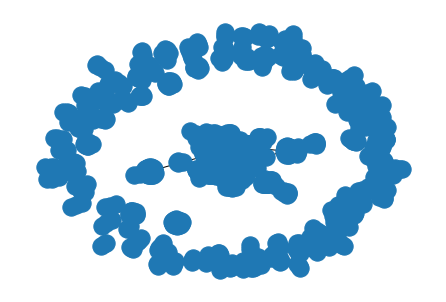

In [48]:
#plotting the first graph without any specifications: 
nx.draw(Gnew)
plt.show()

In [90]:

#plot graph T with the node colour based on the gender. 
#plotting T with node_size depending on betweenness centrality
npos = nx.spring_layout(Gnew, scale=1)
fig = plt.figure(1, figsize=(20,20))
gendercolours = [nx.get_node_attributes(Gnew, "GenderColour")[g] for g in Gnew.nodes()]
nx.draw(Gnew, pos=npos, 
        node_size=[v * 10000 for v in between_centrality_T.values()], 
        #also adding labels
        with_labels=True,
        node_color=gendercolours,
        #node_color = [nx.get_node_attributes(Gnew,'GenderColour')[g] for g in Gnew.nodes()], 
        edge_color="black")
plt.show()

KeyError: 'object5334'

<Figure size 1440x1440 with 0 Axes>

# Refining the plots
With setting some arguments the graph plot can be refined and made better readable. 

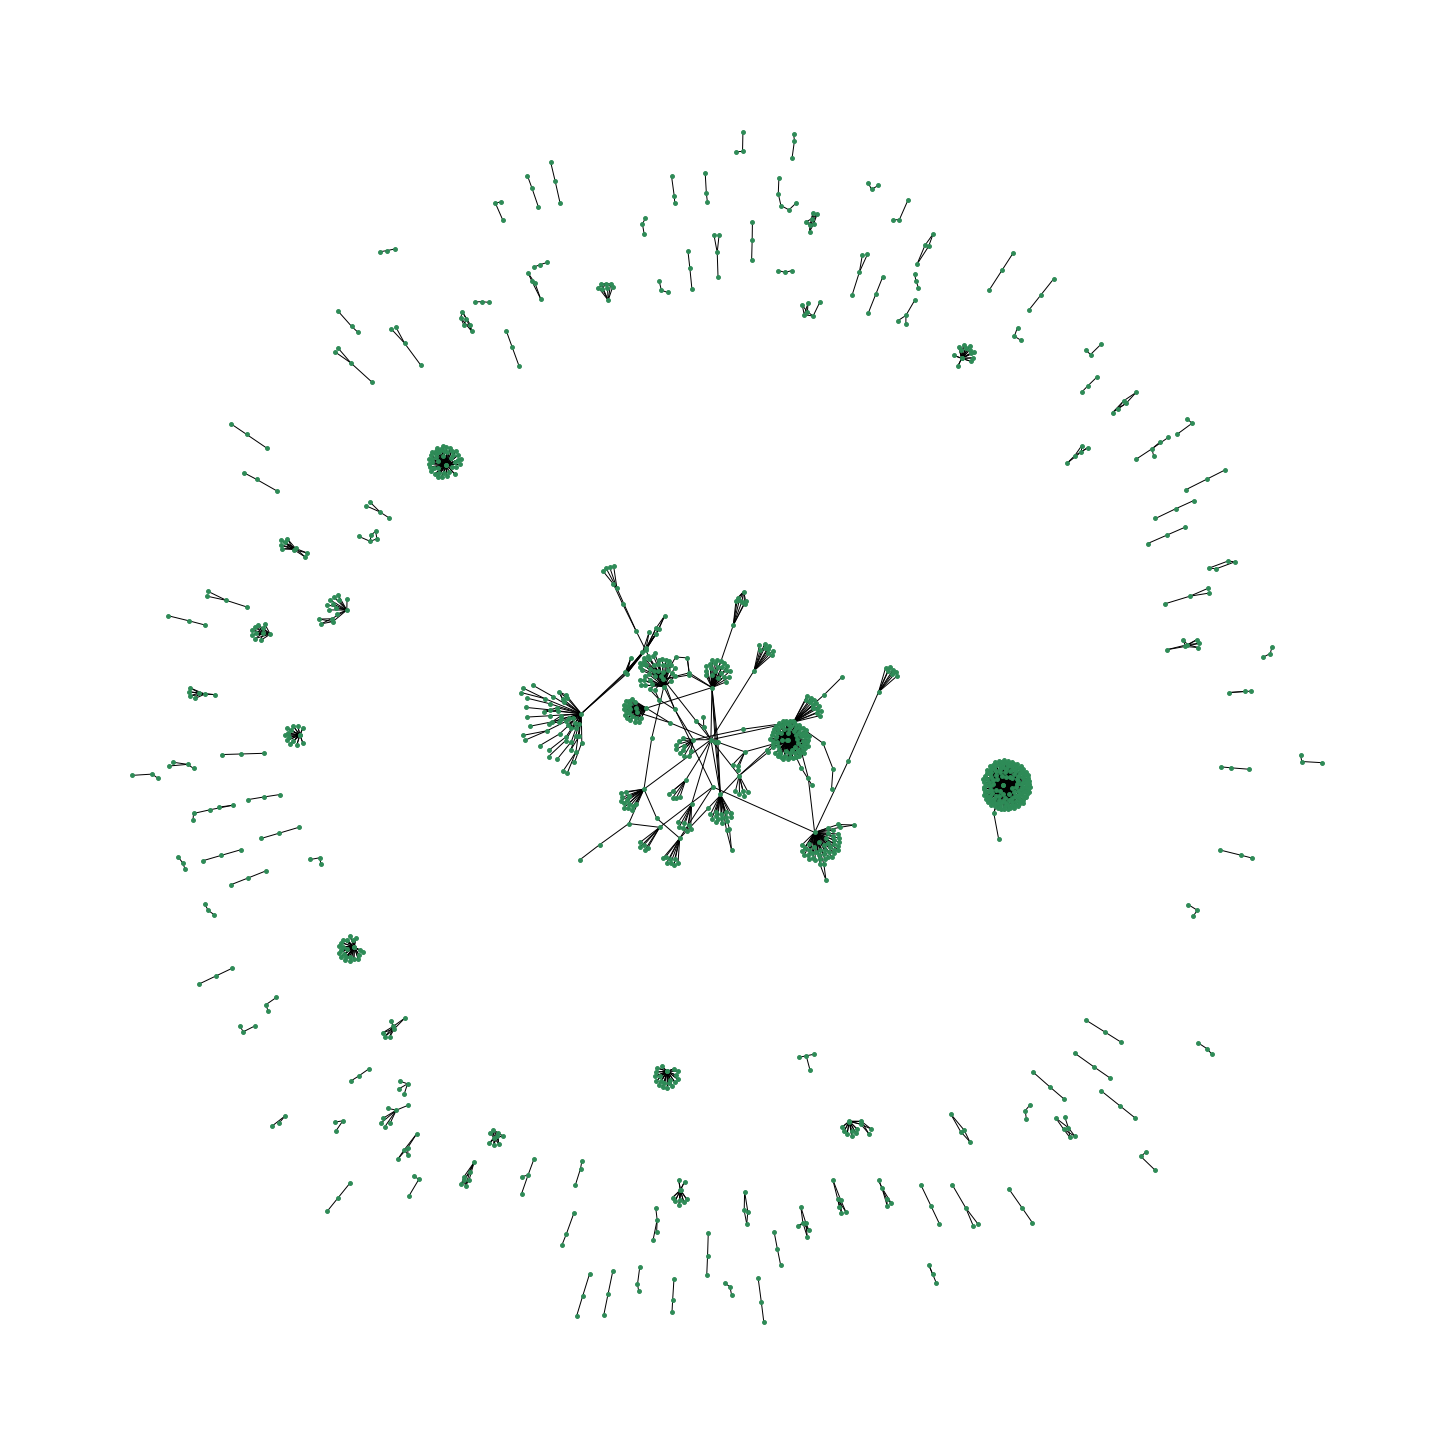

In [49]:
#plotting the same graph but with some arguments 
pos = nx.spring_layout(Gnew, scale=1)
fig = plt.figure(1, figsize=(20,20))
nx.draw(Gnew, with_labels=False, node_color="seagreen", node_size = 15)

##### Exploring the network

In [50]:
#Getting feeling for the size of the graph 
#Count of the nodes:
print("There are", len(Gnew.nodes()), "nodes in the network.")

There are 1190 nodes in the network.


In [51]:
#Count of the edges: 
print("There are", len(Gnew.edges()), "edges in the network.")

There are 1550 edges in the network.


# Investigating the centrality measure of the network: 

## Degree centrality
Finding the network centrality meassures.
Since the network is not directed, we don't need to take in degree and out degree into account. 

In [ ]:
#computing the degree centrality
centrality = nx.degree_centrality(Gnew)
#adding the degree_centrality values as node attributes
nx.set_node_attributes(Gnew, centrality, "DegreeCentrality")

In [ ]:
#plotting the degree distribution of the network
plt.title("Histogram of degree centrality distribution")
plt.hist(list(centrality.values()))
plt.show()

In [ ]:
#importing matplotlib
import matplotlib.cm as cm

In [ ]:
#drawing the graph with nodessizes based on the centrality meassure
pos = nx.spring_layout(Gnew, scale=1)
fig = plt.figure(1, figsize=(30,30))
nx.draw(Gnew, pos=pos, node_size=[v * 1000 for v in centrality.values()])
plt.show()

#### Defining the function *find_nodes_with_highest_deg_cent* 
The function eturns the nodes with the highest degree centrality in the graph. 

In [ ]:
# Defining find_nodes_with_highest_deg_cent()
def find_nodes_with_highest_deg_cent(G):
    '''returns the nodes with the higehst degree centrality in the graph G'''
    # Computing the degree centrality of G: deg_cent
    deg_cent = nx.degree_centrality(G)
    # Computing the maximum degree centrality: max_dc
    max_dc = max(list(deg_cent.values()))
    nodes = set()
    # Iterating over the degree centrality dictionary
    for k, v in deg_cent.items():
        # Checking if the current value has the maximum degree centrality
        if v == max_dc:
            # Adding the current node to the set of nodes
            nodes.add(k)
    return nodes

# Find the node(s) that has the highest degree centrality in G: top_dc
top_dc = find_nodes_with_highest_deg_cent(Gnew)
print("Those are the nodes with the highest degree centrality: ", top_dc)

In [ ]:
# Assertion statement that checks that the node(s) is/are correctly identified.
for node in top_dc:
    assert nx.degree_centrality(Gnew)[node] == max(nx.degree_centrality(Gnew).values())

## Closeness Centrality: 
Assuming that important nodes are closer to other nodes. 
*Closeness centrality* is calucalted as the sum of the path length from the given node to all other nodes. 

In [ ]:
#calculating the closeness centrality:
close_centrality = nx.closeness_centrality(Gnew)
#adding the meassure as node attribute to the graph object
nx.set_node_attributes(Gnew, centrality, "ClosenessCentrality")

In [ ]:
#plotting the closeness centrality of the network as histogram
plt.hist(list(close_centrality.values()))
plt.title("Histogram on Closeness Centrality Distribution")
plt.show()

In [ ]:
#plotting the graph with the node sizes depending on the closeness centrality messure of the nodes.
fig = plt.figure(1, figsize=(30,30))
nx.draw(Gnew, pos = pos, nodelist=close_centrality.keys(), node_color="seagreen", node_size=[v * 10000 for v in close_centrality.values()])
plt.show()

## Betweenness Centrality: 
*Betweenness centrality* is computed under the assumption that important nodes connect other nodes. Nodes with a high betweeness cetnrality act like bridges in the network. 

In [150]:
#calculating the betweeness centrality:
bet_centrality = nx.betweenness_centrality(Gnew)
#adding the betweeness centrality as node attribute to the graph object: 
nx.set_node_attributes(Gnew, bet_centrality, "BetweenessCentrality")

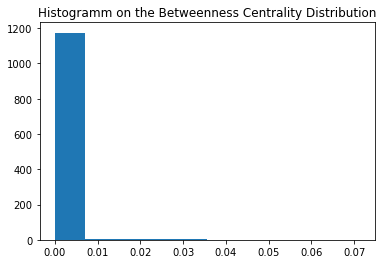

In [151]:
#plotting the degree distribution of the network
plt.hist(list(bet_centrality.values()))
plt.title("Histogramm on the Betweenness Centrality Distribution")
plt.show()

### Finding the Nodes with highest betweenness centrality
Defining the function *summary* that profides us with the nodes that have the highest betweeness centrality. 

In [152]:
# defining the function summary
def summary(G):
    '''
    Getting the values and nodes with the highest betweeness centrality in descending order
    '''
    #use from_dic() to create a dataframe with the keys and vlaues of the bet_centrality object
    df = pd.DataFrame.from_dict({
        'node': list(bet_centrality.keys()),
        'between_centrality': list(bet_centrality.values())
    })
    #sort the values by centrality with descending order:
    return df.sort_values('between_centrality', ascending=False)

In [153]:
top_bet_cent = summary(Gnew)
top_bet_cent.head()

,node,between_centrality
166,artist24409,0.071211
7,artist8595,0.032773
1114,object56092,0.032571
147,object65469,0.027953
100,object69849,0.027426


Subsetting the graphobject on the top 100 nodes with the highest in betweeness centrality meassure. 

In [154]:
#subsetting the dataframe, keeping only the top 100 nodes with the highest betweenness centrality. 
topbet = top_bet_cent.iloc[0:100]
topbet.head()

,node,between_centrality
166,artist24409,0.071211
7,artist8595,0.032773
1114,object56092,0.032571
147,object65469,0.027953
100,object69849,0.027426


### Plotting the new graph object T. 

In [155]:
#Creating new graph object as a subgraph og Gnew only with the top 100 nodes: 
topbet_nodes = topbet["node"]
T = Gnew.subgraph(topbet_nodes)

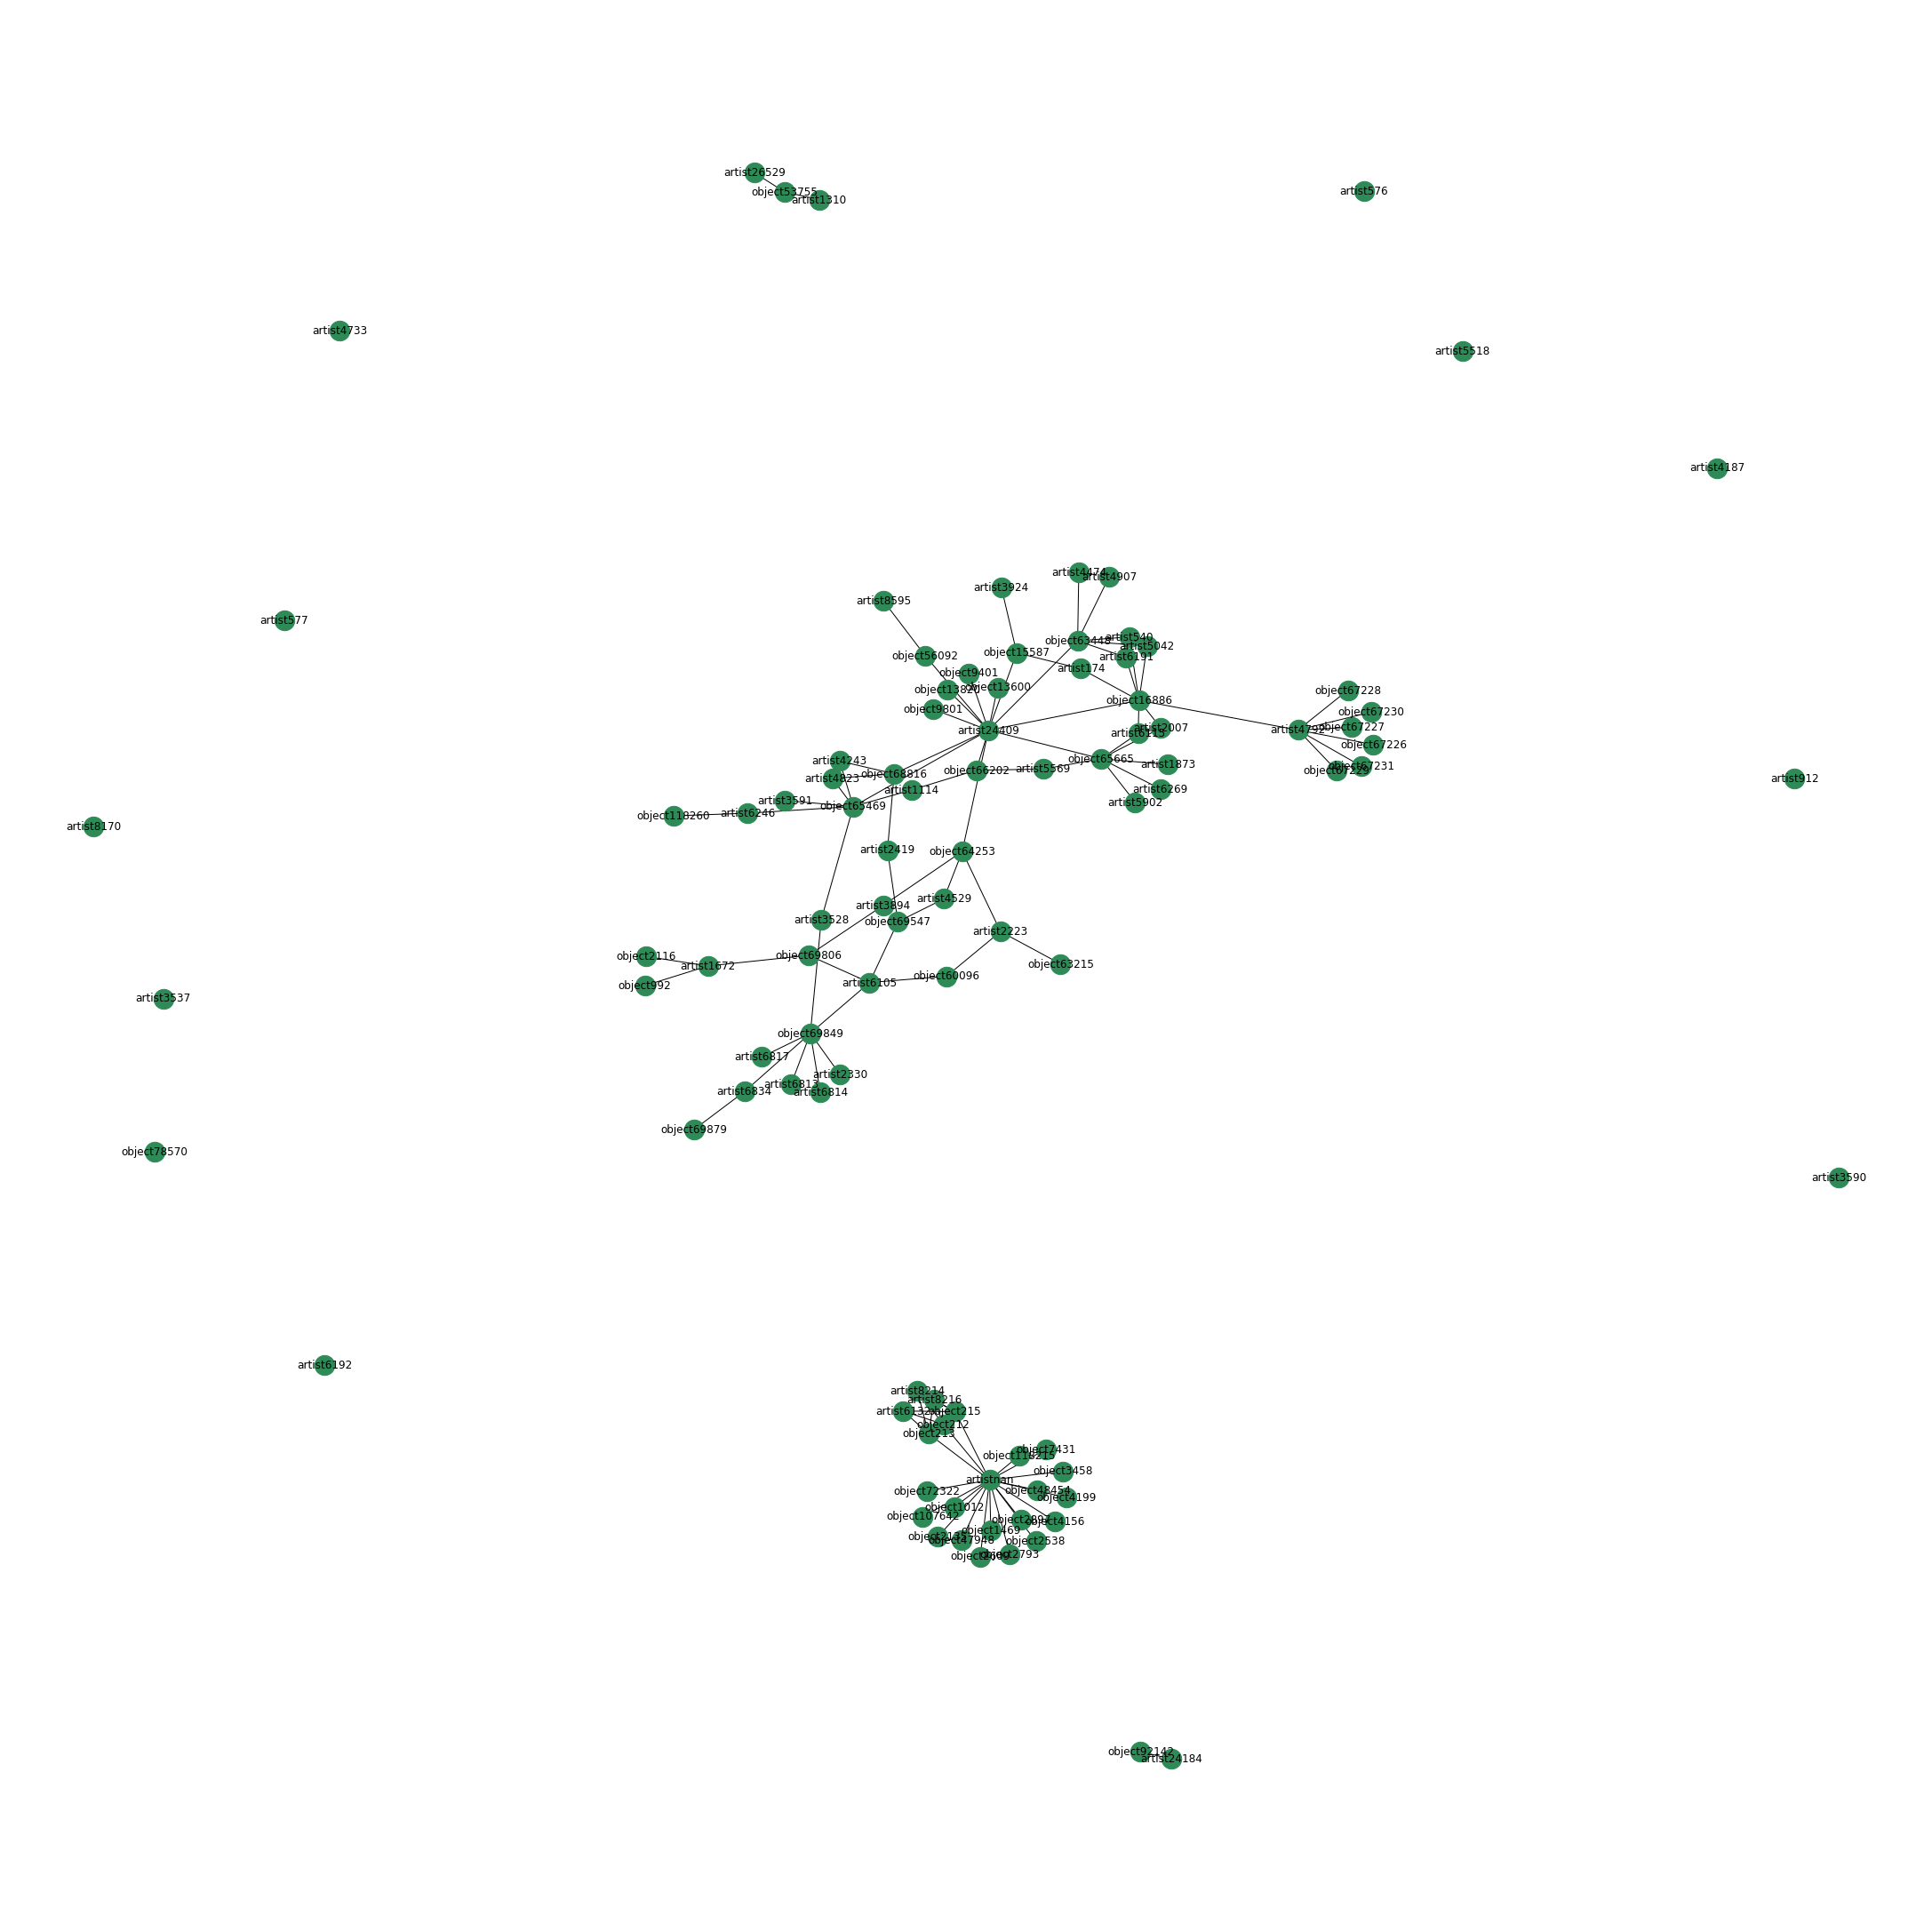

In [159]:
#Plotting the new graph object:
npos = nx.spring_layout(T, scale=1)
fig = plt.figure(1, figsize=(30,30))
nx.draw(T, pos=npos, node_color="seagreen", with_labels = True, node_size=500, edge_color="black")
plt.show()

Plotting the graphobject T with nodes size depending on the betweenness centrality meassure. 

In [ ]:
#calculating the betweenness centrality of the graph object T
between_centrality_T = nx.betweenness_centrality(T)
#plotting T with node_size depending on betweenness centrality
npos = nx.spring_layout(T, scale=1)
fig = plt.figure(1, figsize=(20,20))
nx.draw(T, pos=npos, node_color="seagreen", 
        node_size=[v * 10000 for v in between_centrality_T.values()], 
        #also adding labels
        with_labels=True,
        edge_color="black")
plt.show()

### Defining a function *find_node_with_highest_bet_cent* 
The function returns the nodes with the highest betweeness centrality in the graph G.

In [146]:
# Define find_node_with_highest_bet_cent()
def find_node_with_highest_bet_cent(G):
    '''returns the nodes with the highest betweeness centrality in the graph G.'''
    # Computing betweenness centrality: bet_cent
    bet_cent = nx.betweenness_centrality(G)
    # Computing maximum betweenness centrality: max_bc
    max_bc = max(list(bet_cent.values()))
    nodes = set()
    # Iterating over the betweenness centrality dictionary
    for k, v in bet_cent.items():
        # Checking if the current value has the maximum betweenness centrality
        if v == max_bc:
            # Adding the current node to the set of nodes
            nodes.add(k)
    return nodes

# Using that function to find the node(s) that has the highest betweenness centrality in the network: top_bc
top_bc = find_node_with_highest_bet_cent(Gnew)
print("This is the node with the highest betweeness centrality: ",top_bc)

# Assertion statement that checks that the node(s) is/are correctly identified.
for node in top_bc:
    assert nx.betweenness_centrality(Gnew)[node] == max(nx.betweenness_centrality(Gnew).values())

This is the node with the highest betweeness centrality:  {'artist24409'}


## Neihgbors of nodes
Getting the degree of every nodes in the graph. Plotting a histogram of the degree centrality distribution. 

In [ ]:
#computing the degree of every node: degrees
degrees = [len(list(Gnew.neighbors(n))) for n in Gnew.nodes()]
print(degrees)

In [ ]:
#Plot a histogram of the degree distribution of the graph
plt.figure()
plt.hist(degrees)
plt.title("Histogram of the degree distribution of the graph")
plt.show()

In [ ]:
#Plot a scatter plot of the centrality distribution and the degree distribution
plt.figure()
plt.scatter(degrees, list(centrality.values()))
plt.title("Scatter Plot of the centrality and the degree distribution")
plt.show()

#### Defing the function *nodes_neighbors*
The function *nodes_neighbors*  returns the count of neighbors the nodes have. 

In [ ]:
#defining the function nodes_neighbors
def nodes_neighbors(G):
    """
    Returns the count of neighbors the nodes in G have.
    """
    nodes = set()
    #iterate over all nodes in G
    for n in G.nodes():
        #counting the nodes and adding them to the set:
        nodes.add(len(list(G.neighbors(n))))
        
    #return the neighbor of n
    return nodes


In [ ]:
neighbors = nodes_neighbors(Gnew)
print(neighbors)

#### Defining a functure *nodes_with_m_nrbs* 
The function return all nodes in a graph that have a soecific count of (m) neighbors.

In [ ]:
# Define nodes_with_m_nbrs()
def nodes_with_m_nbrs(G, m):
    """
    Returns all nodes in graph G that have m neighbors.
    """
    nodes = set()

    # Iterate over all nodes in G
    for n in G.nodes():

        # Check if the number of neighbors of n matches m
        if len(list(G.neighbors(n))) == m:

            # Add the node n to the set
            nodes.add(n)

    # Return the nodes with m neighbors
    return nodes

In [ ]:
# Compute and print all nodes in Gnew that have 6 neighbors
six_nbrs = nodes_with_m_nbrs(Gnew, 6)
print(six_nbrs)


In [ ]:
# Compute and print all nodes in Gnew that have 72 neighbors
seventytwo_nbrs = nodes_with_m_nbrs(Gnew, 72)
print(seventytwo_nbrs)

In [ ]:
#checking if there realy is no node with 14 neighbors 
#(As the result shows when using the nodes_neighbors function on Gnew): 
fourteen_nbrs = nodes_with_m_nbrs(Gnew, 14)
print(fourteen_nbrs)

## Investigate Triangles in the graph
Finding nodes that are involved in triangles. The API nx.triangles() returns a dictionary where the nodes are the keys and the values are the number of triangles. 

In [ ]:
#creating a dictionary with the triangles of nodes. 
triangles = nx.triangles(Gnew)

In [ ]:
triangles.get(1)
#nothing is return, there is no node with 1 triangle. 

In [ ]:
triangles_values = list(triangles.values())
print(sorted(triangles_values))

In [ ]:
#complicate way to find out if there are tringles. 
triangles_values = list(triangles.values())
triangles2 = [i for i in triangles_values if i > 1]
print(triangles2)

There are no triangles in the graph object Gnew.Therefore tThe following function is not useful in this case, since there are no nodes in a triangle relationships.
Code was: 
from itertools import combinations
#Function that identifies all nodes in a triangle relationship.
def nodes_in_triangle(G, n):
    """
    Returns the nodes in a graph G that are involved in a triangle relationship.
    """
    triangle_nodes = set([n])
    # Iterating over all possible triangle relationship combinations
    for n1, n2 in combinations(G.neighbors(n), 2):
        # Checking if n1 and n2 have an edge between them
        if G.has_edge(n1, n2) == True:
            # Adding n1 to triangle_nodes
            triangle_nodes.add(n1)
            # Adding n2 to triangle_nodes
            triangle_nodes.add(n2)
    return triangle_nodes

nodes_in_triangle(Gnew, 1)
#shouldn't the result show at least two nodes? 

## Cliques

In [ ]:
#finding all cliques. not very informative in this case. Only holds pairs of two nodes. 
cliques = list(nx.find_cliques(Gnew))
print(cliques[:5])

##### Finding cliques.  
cliques are "groups of nodes that are fully connected to one another", while a maximal clique is a clique that cannot be extended by adding another node in the graph.

In [ ]:
#finding the cliques: 
cliques = nx.find_cliques(Gnew)
cliques

In [ ]:
print("There are", len(list(cliques)), "cliques in the graph")
#why do I get the result 0?

In [ ]:
largest_clique = sorted(nx.find_cliques(Gnew), key=lambda x:len(x))[-1]
print("The largest clique constists of the nodes: ", largest_clique)

When the largest clique constits of only two nodes, there are no real cliques. 